# Diffusion distillation (WiP)

In [ ]:
from functools import partial

import jax
import jax.numpy as np
import flax.linen as nn
import optax
import diffrax as dfx

from sklearn import datasets, preprocessing

import matplotlib.pyplot as plt
from tqdm import trange

## The dataset

We'll use two moons to keep things simple.

(-2.0, 2.0)

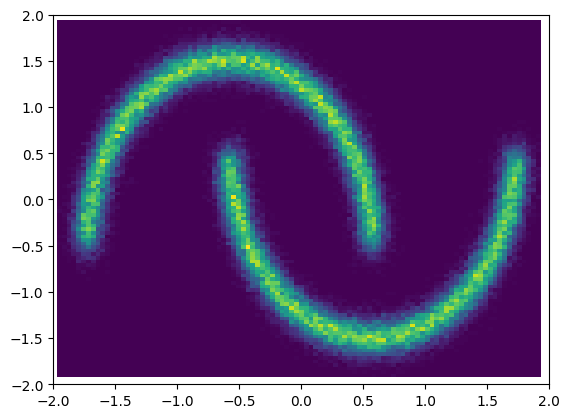

In [34]:
n_samples = 100_000

x, _ = datasets.make_moons(n_samples=n_samples, noise=.06)

scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)

plt.hist2d(x[:, 0], x[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

In [35]:
sigma = 1.

def weight(t):
    """ \lambda(t)
    """
    return 0.5 / np.log(sigma) * (sigma ** (2 * t) - 1)

@partial(jax.jit, static_argnums=(3,))
def loss_fn(params, x, t, score, key):

    mu = x  # x(0)
    std = np.sqrt(0.5 / np.log(sigma) * (sigma ** (2 * t) - 1))  # std of noise at time t

    eps = jax.random.normal(key, shape=x.shape)  # Sampled noise
    y = mu + std * eps  # x(t) = x(0) + std * eps  # Corrupted data

    # Predicted score
    pred = score.apply(params, np.concatenate([t, y], -1))  

    # Score matching loss
    loss = weight(t) * np.mean((pred + eps / std) ** 2)

    return loss.mean()

In [36]:
class MLP(nn.Module):
    """ A simple MLP in Flax. This is the score function.
    """
    hidden_dim: int = 32
    out_dim: int = 2
    n_layers: int = 2

    @nn.compact
    def __call__(self, x):
        for _ in range(self.n_layers):
            x = nn.Dense(features=self.hidden_dim)(x)
            x = nn.gelu(x)
        x = nn.Dense(features=self.out_dim)(x)
        return x

In [37]:
def int_beta(t):
    return t

def weight(t):
    return 1 - np.exp(-int_beta(t))

@partial(jax.jit, static_argnums=(3,4,))
def loss_fn(params, x, t, int_beta, score, key):
    mu = x * np.exp(-0.5 * int_beta(t))
    sigma = np.sqrt(1 - np.exp(-int_beta(t)))
    eps = jax.random.normal(key, shape=x.shape)
    y = mu + sigma * eps

    pred = score.apply(params, np.concatenate([y, t], -1))
    loss = weight(t) * np.mean((pred + eps / sigma) ** 2)
    return loss.mean()

In [38]:
key = jax.random.PRNGKey(0)
t = np.ones((x.shape[0], 1))

score = MLP(hidden_dim=128, out_dim=2, n_layers=5)
params = score.init(key, np.concatenate([x, t], axis=1))

## Training

In [39]:
opt = optax.adamw(learning_rate=3e-4, weight_decay=1e-4)
opt_state = opt.init(params)

In [40]:
n_steps = 2_000
n_batch = 128
T = 1.

with trange(n_steps) as steps:
    for step in steps:

        # Draw a random batches from x
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(n_batch,))
        
        x_batch = x[idx]
        t_batch = jax.random.uniform(key, shape=(x_batch.shape[0], 1), minval=0., maxval=T)

        loss, grads = jax.value_and_grad(loss_fn)(params, x_batch, t_batch, int_beta, score, key)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(val=loss)

100%|██████████| 2000/2000 [00:17<00:00, 112.91it/s, val=2.2799215] 


## Distillation

In [41]:
key = jax.random.PRNGKey(0)
t = np.ones((x.shape[0], 1))

score_student = MLP(hidden_dim=128, out_dim=2, n_layers=5)
params_student = score_student.init(key, np.concatenate([x, t], axis=1))

In [45]:
n_steps = 5_000
n_batch = 128

def alpha(t):
    return np.exp(-0.5 * int_beta(t))

def sigma(t):
    return np.sqrt(1 - np.exp(-int_beta(t)))

@partial(jax.jit, static_argnums=(4,5,))
def loss_distillation_fn(params_student, params, x, t, score_student, score, key):
    eps = jax.random.normal(key, shape=x.shape)

    t = t[:, None] 

    z_t = alpha(t) * x + sigma(t) * eps

    t_p = t - 0.5 / N
    t_pp = t - 1 / N

    x_hat_t = score.apply(params, np.concatenate([z_t, t], -1))
    z_tp = alpha(t_p) * x_hat_t + sigma(t_p) / sigma(t) * (z_t - x_hat_t * alpha(t))

    x_hat_tp = score.apply(params, np.concatenate([z_tp, t], -1))
    z_tpp = alpha(t_pp) * x_hat_tp + sigma(t_pp) / sigma(t_p) * (z_t - x_hat_tp * alpha(t_p))

    x_tilde = (z_tpp - (sigma(t_pp) / sigma(t)) * z_t) / (alpha(t_pp) - (sigma(t_pp) / sigma(t)) * alpha(t))

    pred = score_student.apply(params_student, np.concatenate([z_t, t], -1))
    loss = weight(t) * np.mean((pred + (x_tilde - x * alpha(t)) / sigma(t) ** 2) ** 2)
    return loss.mean()

N = 100

with trange(n_steps) as steps:
    for step in steps:

        # Draw a random batches from x
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(n_batch,))
        
        x_batch = x[idx]
        t_batch = jax.random.choice(key, np.arange(1, N + 1), shape=(n_batch,)) / N

        loss, grads = jax.value_and_grad(loss_distillation_fn)(params_student, params, x_batch, t_batch, score_student, score, key)
        updates, opt_state = opt.update(grads, opt_state, params_student)

        params_student = optax.apply_updates(params_student, updates)

        steps.set_postfix(val=loss)

100%|██████████| 5000/5000 [00:50<00:00, 98.17it/s, val=4.15465]    


## Sampling